In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/dataset/

/content/drive/MyDrive/dataset


In [ ]:
!unzip "Real and Fake Face Detection Dataset.zip"

Archive:  Real and Fake Face Detection Dataset.zip
   creating: Real and Fake Face Detection Dataset/
  inflating: __MACOSX/._Real and Fake Face Detection Dataset  
  inflating: Real and Fake Face Detection Dataset/.DS_Store  
  inflating: __MACOSX/Real and Fake Face Detection Dataset/._.DS_Store  
   creating: Real and Fake Face Detection Dataset/Real/
  inflating: __MACOSX/Real and Fake Face Detection Dataset/._Real  
   creating: Real and Fake Face Detection Dataset/Fake/
  inflating: __MACOSX/Real and Fake Face Detection Dataset/._Fake  
  inflating: Real and Fake Face Detection Dataset/Real/real_00251.jpg  
  inflating: __MACOSX/Real and Fake Face Detection Dataset/Real/._real_00251.jpg  
  inflating: Real and Fake Face Detection Dataset/Real/real_00537.jpg  
  inflating: __MACOSX/Real and Fake Face Detection Dataset/Real/._real_00537.jpg  
  inflating: Real and Fake Face Detection Dataset/Real/real_00523.jpg  
  inflating: __MACOSX/Real and Fake Face Detection Dataset/Real/._real

In [ ]:
import os
import shutil
import random
from PIL import Image

def is_image_file(filename):
    # Check if a file is an image file based on the extension
    extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']
    for ext in extensions:
        if filename.lower().endswith(ext):
            return True
    return False

def split_data(source_dir, train_dir, val_dir, test_dir, train_size=0.7, val_size=0.15, test_size=0.15):
    assert train_size + val_size + test_size == 1, "Train, validation and test sizes must sum to 1."

    for category in os.listdir(source_dir):
        category_path = os.path.join(source_dir, category)
        if not os.path.isdir(category_path):
            continue

        images = [image for image in os.listdir(category_path) if is_image_file(image)]
        random.shuffle(images)

        train_split = int(len(images) * train_size)
        val_split = int(len(images) * (train_size + val_size))

        train_images = images[:train_split]
        val_images = images[train_split:val_split]
        test_images = images[val_split:]

        for image in train_images:
            shutil.copy(os.path.join(category_path, image), os.path.join(train_dir, category, image))

        for image in val_images:
            shutil.copy(os.path.join(category_path, image), os.path.join(val_dir, category, image))

        for image in test_images:
            shutil.copy(os.path.join(category_path, image), os.path.join(test_dir, category, image))

# Set the base directory in Google Drive
base_dir = '/content/drive/My Drive/dataset/Real and Fake Face Detection Dataset'
os.makedirs(base_dir, exist_ok=True)

# Create necessary directories
data_dir = '/content/drive/My Drive/dataset/Split Data'
os.makedirs(data_dir, exist_ok=True)

train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

for category in ['Fake', 'Real']:
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(val_dir, category), exist_ok=True)
    os.makedirs(os.path.join(test_dir, category), exist_ok=True)

# Source directory containing the dataset
source_dir = '/content/drive/My Drive/dataset/Real and Fake Face Detection Dataset'

# Split the data
split_data(source_dir, train_dir, val_dir, test_dir)


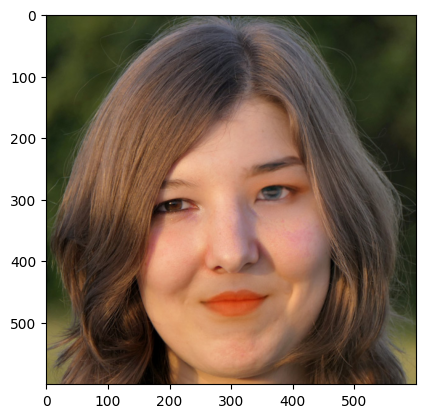

In [ ]:
import matplotlib.pyplot as plt

# Define the image path
image_path = "/content/drive/MyDrive/dataset/Split Data/test/Fake/easy_102_0101.jpg"  # Replace with your actual path

# Read the image using imread
image = plt.imread(image_path)

# Display the image
plt.imshow(image)
plt.show()


In [ ]:


def preprocess_image(image_path, target_size=(224, 224)):
    # Load and resize the image, then save it to the same path
    with Image.open(image_path) as img:
        img = img.resize(target_size)
        img.save(image_path)

def preprocess_dataset(directory):
    for category in os.listdir(directory):
        category_path = os.path.join(directory, category)
        if not os.path.isdir(category_path):
            continue

        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            if is_image_file(image_path):
                preprocess_image(image_path)

# Define the paths to your split data directories
train_dir = '/content/drive/My Drive/dataset/Split Data/train'
val_dir = '/content/drive/My Drive/dataset/Split Data/val'
test_dir = '/content/drive/My Drive/dataset/Split Data/test'

# Preprocess the images in the training, validation, and test directories
preprocess_dataset(train_dir)
preprocess_dataset(val_dir)
preprocess_dataset(test_dir)


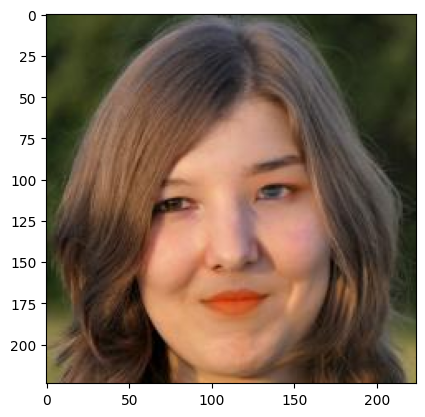

In [ ]:
# Define the image path
image_path = "/content/drive/MyDrive/dataset/Split Data/test/Fake/easy_102_0101.jpg"  # Replace with your actual path

# Read the image using imread
image = plt.imread(image_path)

# Display the image
plt.imshow(image)
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Set your directories and parameters
train_dir = '/content/drive/My Drive/dataset/Split Data/train'
val_dir = '/content/drive/My Drive/dataset/Split Data/val'
test_dir = '/content/drive/My Drive/dataset/Split Data/test'
input_shape = (224, 224, 3)  # Update to 224x224
batch_size = 32
epochs = 10

# Use VGG16 as the base model, excluding the top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add your own classification layers on top
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Data augmentation for training set
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=15,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

# Data augmentation for validation and test sets (only rescaling)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Set up generators for training, validation, and test sets
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(224, 224),  # Update to 224x224
                                                    batch_size=batch_size,
                                                    class_mode='binary')

val_generator = val_datagen.flow_from_directory(val_dir,
                                                target_size=(224, 224),  # Update to 224x224
                                                batch_size=batch_size,
                                                class_mode='binary')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(224, 224),  # Update to 224x224
                                                  batch_size=batch_size,
                                                  class_mode='binary',
                                                  shuffle=False)

# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=epochs,
                    validation_data=val_generator,
                    validation_steps=len(val_generator))



# Print train and val accuracies
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
print(f'Train accuracy: {train_acc[-1]}')
print(f'Validation accuracy: {val_acc[-1]}')



58889256/58889256 [==============================] - 3s 0us/step
Found 1428 images belonging to 2 classes.
Found 306 images belonging to 2 classes.
Found 307 images belonging to 2 classes.
Epoch 1/10
45/45 [==============================] - 988s 22s/step - loss: 1.2452 - accuracy: 0.5245 - val_loss: 0.6895 - val_accuracy: 0.5294
Epoch 2/10
45/45 [==============================] - 973s 22s/step - loss: 0.6727 - accuracy: 0.5791 - val_loss: 0.6590 - val_accuracy: 0.6307
Epoch 3/10
45/45 [==============================] - 977s 22s/step - loss: 0.6701 - accuracy: 0.5679 - val_loss: 0.6659 - val_accuracy: 0.6307
Epoch 4/10
45/45 [==============================] - 964s 21s/step - loss: 0.6632 - accuracy: 0.5777 - val_loss: 0.6507 - val_accuracy: 0.6340
Epoch 5/10
45/45 [==============================] - 967s 21s/step - loss: 0.6585 - accuracy: 0.6036 - val_loss: 0.6564 - val_accuracy: 0.6275
Epoch 6/10
45/45 [==============================] - 966s 21s/step - loss: 0.6657 - accuracy: 0.5952 -

In [ ]:
# Evaluate on test set
loss, accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f'Test accuracy: {accuracy}')

10/10 [==============================] - 172s 17s/step - loss: 0.6495 - accuracy: 0.5993
Test accuracy: 0.5993485450744629


Found 307 images belonging to 2 classes.
1/1 [==============================] - 17s 17s/step


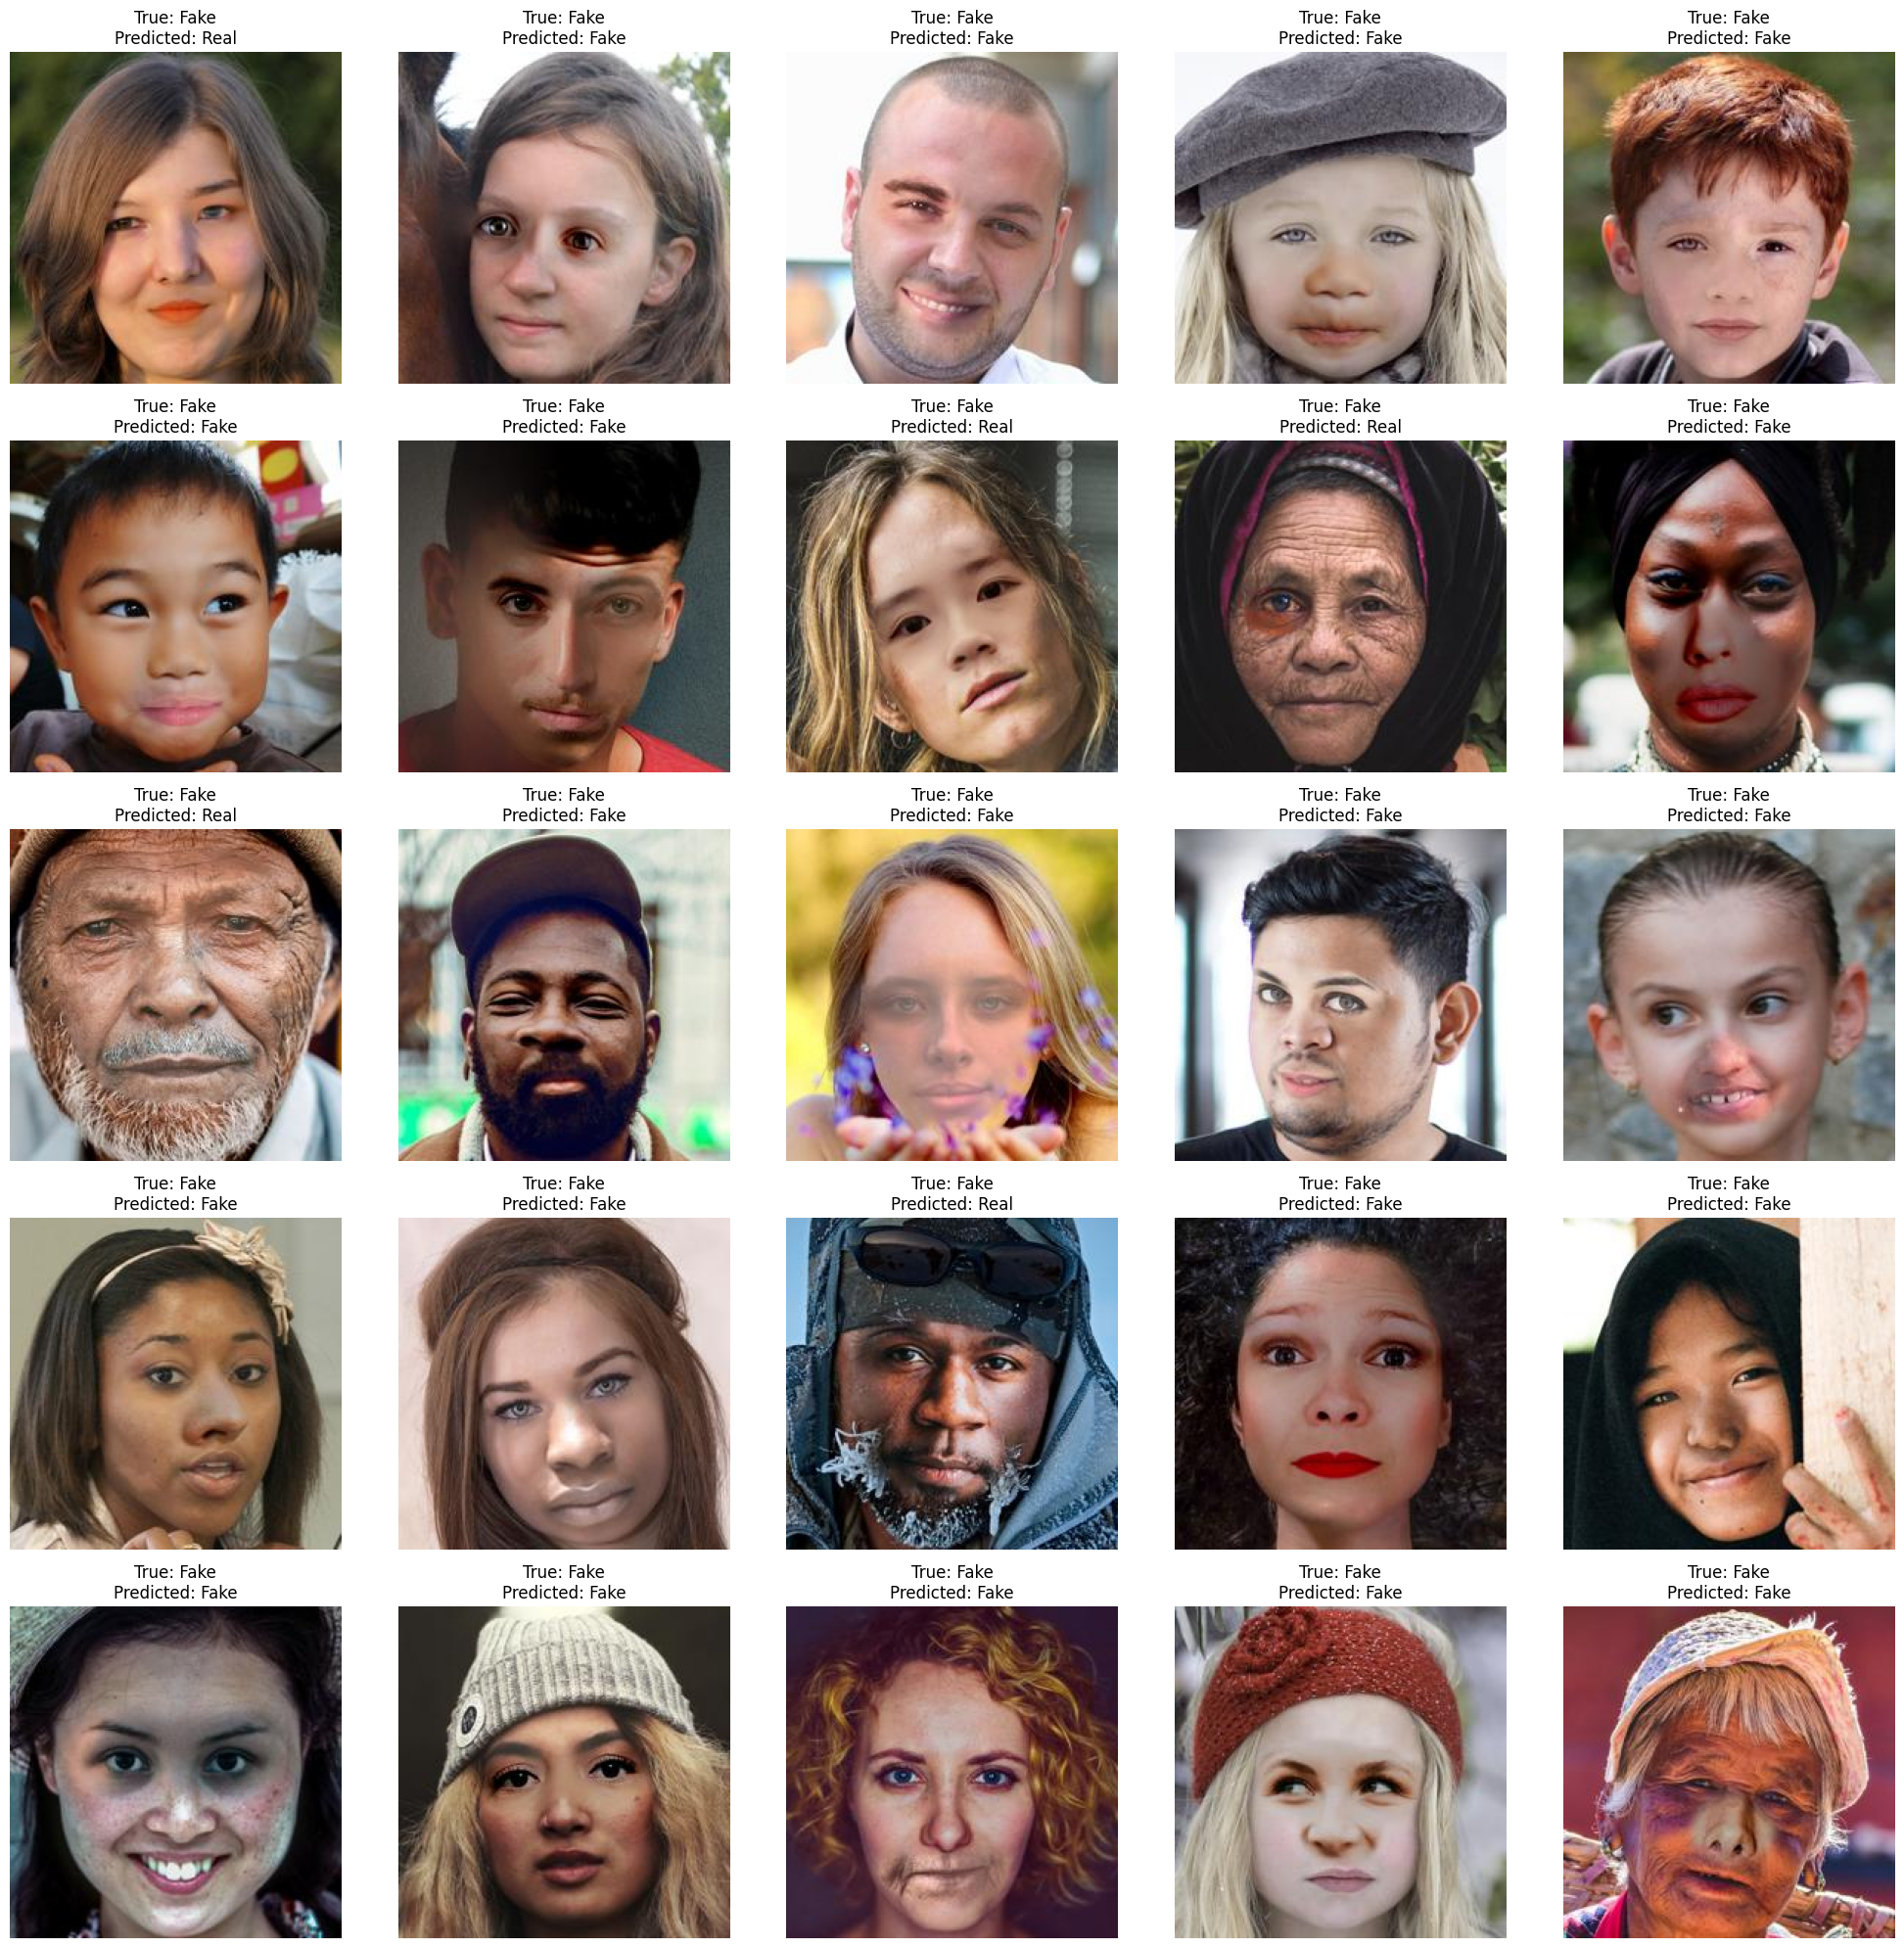

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator



# Data augmentation for test sets (only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# Set up generator for the test set
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(224, 224),  # Update to 224x224
                                                  batch_size=batch_size,
                                                  class_mode='binary',
                                                  shuffle=False)

# Get a batch of test images and labels
test_images, test_labels = next(test_generator)

# Make predictions
predictions = model.predict(test_images)

# Convert predictions to binary labels (0 or 1)
predicted_labels = (predictions > 0.5).astype(int).flatten()



def display_images_with_labels(images, true_labels, predicted_labels, class_indices, num_images=20):
    rows = num_images // 5 + (num_images % 5 > 0)  # Calculate the number of rows needed
    cols = 5  # Set a fixed number of columns
    fig, axes = plt.subplots(rows, cols, figsize=(20, 4 * rows))  # Adjust the figure size

    # Flatten axes for easy iteration
    axes = axes.flatten()

    for i in range(num_images):
        axes[i].imshow(images[i])
        true_label = list(class_indices.keys())[list(class_indices.values()).index(true_labels[i])]
        predicted_label = list(class_indices.keys())[list(class_indices.values()).index(predicted_labels[i])]
        axes[i].set_title(f"True: {true_label}\nPredicted: {predicted_label}")
        axes[i].axis('off')

    # Hide any unused subplots
    for ax in axes[num_images:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()



# Get class indices (mapping from class label to class index)
class_indices = test_generator.class_indices

# Display images with true and predicted labels
display_images_with_labels(test_images, test_labels, predicted_labels, class_indices, num_images=25)
